<a href="https://colab.research.google.com/github/jrodriguezshaw/mlprodobl/blob/main/Documentacion%20final%20del%20entrenamiento_obl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Obligatorio - Machine Learning en Producción**

Entrenamiento del modelo con los datos previamente recabados

Inicializaciond el proyecto, cargando los utilitarios necesarios.

In [19]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

#!pip install tensorflow-io
!pip install azure-storage-blob
#!pip install azure-storage-file-share
!pip install split-folders
!mkdir img
!mkdir dataset
!pip install gradio

#Imports
import os
import io
import matplotlib.pyplot as plt
import splitfolders
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from azure.storage.blob import BlobServiceClient, BlobClient
from PIL import Image



Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
mkdir: cannot create directory ‘img’: File exists
mkdir: cannot create directory ‘dataset’: File exists


In [6]:
import warnings
!pip install wandb
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import wandb
from wandb.keras import WandbCallback

#wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=c5072544bb9b96ea9eff3c1f8dcf2227732fc549f12755b9cb9522d665999777
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


# Datos de conexión

In [20]:
connection_string = "DefaultEndpointsProtocol=https;AccountName=azureworkspace5122300523;AccountKey=syBgKmFWZo1V5lTFRdP0M5RBEN//C715NzT3mIUkTIWF9slf2+GhBpyaS6R/DPaob3dfWfqtV0TH+ASttXbJMQ==;EndpointSuffix=core.windows.net"
container_name = "blob-storage"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

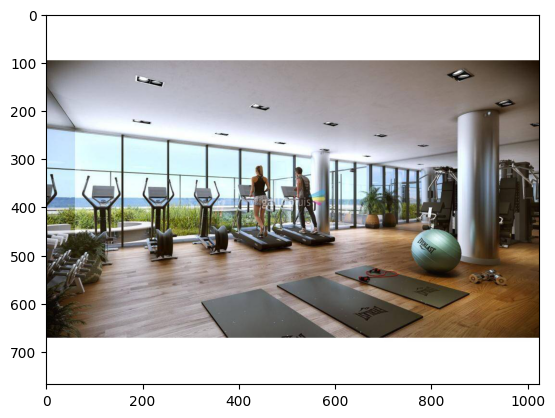

In [21]:
# Corroboramos que se pueda entrar en Azure
try:
    blob_name = 'full/Apartamento_15968017_15c40bb94e0f3ad419adc859f3d9293c55b82c59.jpg'
    blob_client = blob_service_client.get_blob_client(container_name, blob_name)
    stream = io.BytesIO()
    download_stream = blob_client.download_blob()
    stream.write(download_stream.readall())

    stream.seek(0)
    image = Image.open(stream)

    plt.imshow(image)
    plt.show()

except Exception as ex:
    print('Exception:')
    print(ex)

# Cargar localmente las imagenes del Blob de Azure

##Se tiene dos funciones:


1.   La primer revisa la carpeta de Azure y nos dice que cantidad  de elementos dentro de la carpeta
2.   La segunda se encarga de descargar las imagenes dentro de la carpeta de img

Obs: los path de las carpetas de img cambian segun donde se corra el notebook(Azure o Colab).


In [22]:
class Util:
  def length(self,folder):
    container_client =  blob_service_client.get_container_client(container_name)
    blobs_list = container_client.list_blobs(folder)
    my_list = list(blobs_list)
    print("Cantidad de elementos en la carpeta "+ folder+":")
    print(len(my_list))


In [ ]:
# para borrar las carpetas en caso de que cambie el data set
#rm -r /content/img

In [23]:
# Carga de Datos.
#LOCAL_BLOB_PATH = "Users/JR288624/Obl/img" # para Azure Jupyterlab
LOCAL_BLOB_PATH = "/content/img"
BLOBNAME="test"
class AzureBlobFileDownloader:
   def __init__(self):
        print("Intializing AzureBlobFileDownloader")
        self.blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        self.my_container = self.blob_service_client.get_container_client(container_name)
   def save_blob(self, file_name, file_content):
            # Get full path to the file
        download_file_path = os.path.join(LOCAL_BLOB_PATH, file_name)
        os.makedirs(os.path.dirname(download_file_path), exist_ok=True)
        with open(download_file_path, "wb") as file:
            file.write(file_content)


   def download_all_blobs_in_container(self,folder):
        my_blobs = self.my_container.list_blobs(folder)
        cantidad=0
        for blob in my_blobs:
            #print(blob.name)
            cantidad=cantidad+1
            bytes = self.my_container.get_blob_client(blob).download_blob().readall()
            self.save_blob(blob.name, bytes)
        print("cantidad de elementos descargados:")
        print(cantidad)

util = Util()
azure_blob_file_downloader = AzureBlobFileDownloader()
util.length("Casa")
azure_blob_file_downloader.download_all_blobs_in_container("Casa")
util.length("Apartamento")
azure_blob_file_downloader.download_all_blobs_in_container("Apartamento")



Intializing AzureBlobFileDownloader
Cantidad de elementos en la carpeta Casa:
688
cantidad de elementos descargados:
688
Cantidad de elementos en la carpeta Apartamento:
655
cantidad de elementos descargados:
655


# EAS

### Division de Dataset inicial en 3.
1. 70% para el entrenamiento
2. 15% para validacion
3. 15% para test.


In [11]:
#Para Azure Jupyterlab
#IMAGE_PATH='Users/JR288624/Obl/img'
#base_uri='Obl/dataset'
IMAGE_PATH='/content/img'
base_uri='/content/dataset'
print(IMAGE_PATH)
splitfolders.ratio(IMAGE_PATH, output=(base_uri), seed=1337, ratio=(.7, .15, .15))
print("split done!")


/content/img


Copying files: 1343 files [00:00, 2068.52 files/s]

split done!


 ### Cargar y normalizar el conjunto de datos

 La clase ImageDataGenerator en Keras proporciona un conjunto de técnicas para escalar los valores de píxeles en nuestro dataset de imágenes antes del modelado.

In [12]:
#data generator
datagen = ImageDataGenerator()
# Batch de 64
# load
train_ds = datagen.flow_from_directory(base_uri+'/train', class_mode='categorical', batch_size=64)
# load
val_ds = datagen.flow_from_directory(base_uri+'/val/', class_mode='categorical', batch_size=64)
# load
test_ds = datagen.flow_from_directory(base_uri+'/test/', class_mode='categorical', batch_size=64)

Found 939 images belonging to 2 classes.
Found 201 images belonging to 2 classes.
Found 203 images belonging to 2 classes.


In [13]:
#Vemos si hay scale
batch_trainX, batchTrain_y = train_ds.next()
batch_valX, batchval_y = val_ds.next()
batch_testX, batchtest_y = test_ds.next()
print('Batch train ,shape=%s,shapey=%s, min=%.3f, max=%.3f, mean=%.3f,std=%.3f' % (batch_trainX.shape,batchTrain_y.shape, batch_trainX.min(), batch_trainX.max(),batch_trainX.mean(),batch_trainX.std()))
print('Batch val shape=%s, min=%.3f, max=%.3f, mean=%.3f,std=%.3f' % (batch_valX.shape, batch_valX.min(), batch_valX.max(),batch_valX.mean(),batch_valX.std()))
print('Batch test shape=%s, min=%.3f, max=%.3f, mean=%.3f,std=%.3f' % (batch_testX.shape, batch_testX.min(), batch_testX.max(),batch_testX.mean(),batch_testX.std()))

Batch train ,shape=(64, 256, 256, 3),shapey=(64, 2), min=0.000, max=255.000, mean=147.847,std=79.010
Batch val shape=(64, 256, 256, 3), min=0.000, max=255.000, mean=150.601,std=77.419
Batch test shape=(64, 256, 256, 3), min=0.000, max=255.000, mean=152.751,std=76.278


Podemos notar que las fotos son 256*256  con 3 canales en batch de 64.
Tambien notamos que las desviacion estandar es muy parecida entre los distintos sets.

 ### Transform pattern

"Transform pattern" en el contexto de Machine Learning se refiere a la técnica de manipular y cambiar los datos de entrada antes de que sean utilizados por un modelo.

Estos cambios pueden ayudar a mejorar el rendimiento del modelo y a hacer que el modelo sea más robusto ante variaciones en los datos de entrada.

Las transformaciones se aplican típicamente durante la etapa de preprocesamiento de los datos y pueden implicar muchas técnicas diferentes, dependiendo del tipo de datos y del problema que se está tratando de resolver.

En el caso de las imágenes, los patrones de transformación comunes incluyen la normalización (donde se ajusta la escala de los valores de los píxeles), la rotación, el cambio de tamaño, el recorte, la inversión horizontal/vertical (flip), el cambio de color, el zoom, entre otros.

In [14]:
# Define el preprocesamiento de la imagen
data_augmentation = Sequential([
    preprocessing.Rescaling(1./255),
    preprocessing.RandomRotation(0.15),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomTranslation(0.1, 0.1),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomCrop(64, 64)
 ])

# Definición del modelo

### Modelo 1

In [ ]:
# Definimos un modelo
model1 = tf.keras.models.Sequential([
    data_augmentation,  # Agrega las capas de preprocesamiento al inicio del modelo

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compila y entrena el modelo
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history1 = model1.fit(batch_trainX, batchTrain_y, batch_size=128, epochs=20, validation_data=(batch_valX, batchval_y))
model1.save('obl_model1.h5')
#model.save_weights('obl_model1_w.h5')

Epoch 1/20
1/1 [==============================] - 11s 11s/step - loss: 1.3824 - accuracy: 0.5625 - val_loss: 0.6840 - val_accuracy: 0.5781
Epoch 2/20
1/1 [==============================] - 3s 3s/step - loss: 1.0471 - accuracy: 0.5469 - val_loss: 0.6775 - val_accuracy: 0.5938
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 0.8618 - accuracy: 0.7344 - val_loss: 0.7211 - val_accuracy: 0.4219
Epoch 4/20
1/1 [==============================] - 4s 4s/step - loss: 1.2195 - accuracy: 0.6875 - val_loss: 0.8248 - val_accuracy: 0.4219
Epoch 5/20
1/1 [==============================] - 4s 4s/step - loss: 1.4714 - accuracy: 0.6094 - val_loss: 0.8913 - val_accuracy: 0.4219
Epoch 6/20
1/1 [==============================] - 3s 3s/step - loss: 1.2077 - accuracy: 0.6094 - val_loss: 0.9082 - val_accuracy: 0.4219
Epoch 7/20
1/1 [==============================] - 3s 3s/step - loss: 1.2839 - accuracy: 0.5312 - val_loss: 0.8866 - val_accuracy: 0.4219
Epoch 8/20
1/1 [=======================

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)      

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


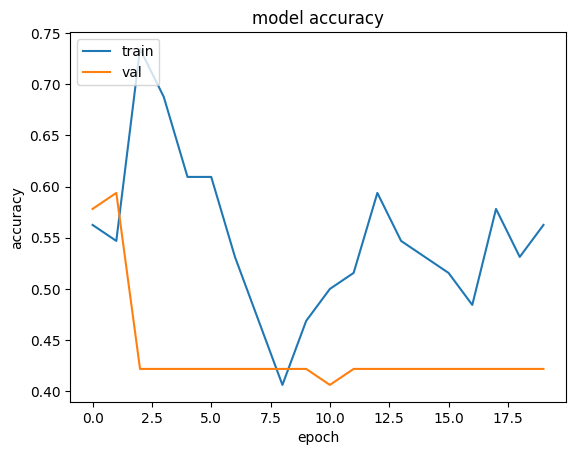

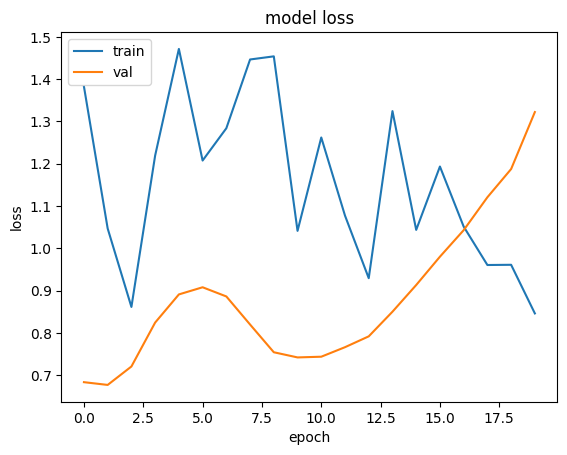

In [ ]:
print(history1.history.keys())
# summarize history for accuracy durante el entrenamiento
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss  durante el entrenamiento
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# evaluate model1
loss, acc = model1.evaluate_generator(test_ds, steps=len(test_ds), verbose=0)
print('Test loss: %.3f' % (loss))
print('Test Accuracy: %.3f' % (acc))

Test loss: 1.144
Test Accuracy: 0.488


### Modelo 2

In [ ]:
width, height, channels = batch_trainX.shape[1], batch_trainX.shape[2], 3
model2 = tf.keras.models.Sequential([
    data_augmentation,  # Agrega las capas de preprocesamiento al inicio del modelo

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(width, height, channels)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compila y entrena el modelo
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(batch_trainX, batchTrain_y, batch_size=64, epochs=30, validation_data=(batch_valX, batchval_y))
model2.save('obl_model2.h5')

Epoch 1/30
1/1 [==============================] - 6s 6s/step - loss: 0.6922 - accuracy: 0.5156 - val_loss: 0.9405 - val_accuracy: 0.4219
Epoch 2/30
1/1 [==============================] - 2s 2s/step - loss: 0.9136 - accuracy: 0.4688 - val_loss: 1.5889 - val_accuracy: 0.5781
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 1.6627 - accuracy: 0.5312 - val_loss: 0.8609 - val_accuracy: 0.5781
Epoch 4/30
1/1 [==============================] - 2s 2s/step - loss: 0.8845 - accuracy: 0.5312 - val_loss: 0.6826 - val_accuracy: 0.5781
Epoch 5/30
1/1 [==============================] - 3s 3s/step - loss: 0.6992 - accuracy: 0.5312 - val_loss: 0.6938 - val_accuracy: 0.4531
Epoch 6/30
1/1 [==============================] - 3s 3s/step - loss: 0.6930 - accuracy: 0.5312 - val_loss: 0.6996 - val_accuracy: 0.4219
Epoch 7/30
1/1 [==============================] - 2s 2s/step - loss: 0.6938 - accuracy: 0.4844 - val_loss: 0.6924 - val_accuracy: 0.5156
Epoch 8/30
1/1 [=========================

In [4]:
print(history2.history.keys())
# summarize history for accuracy durante el entrenamiento
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss  durante el entrenamiento
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
# evaluate model2
loss, acc = model2.evaluate_generator(test_ds, steps=len(test_ds), verbose=0)
print('Test loss: %.3f' % (loss))
print('Test Accuracy: %.3f' % (acc))

Test loss: 0.717
Test Accuracy: 0.512


Modelo 3

In [15]:
model3 = tf.keras.models.Sequential([
      data_augmentation , # Agrega las capas de preprocesamiento al inicio del modelo

      tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(2, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(2, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(2, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(2, activation='softmax')
])

# Compila y entrena el modelo
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
history3 = model3.fit(batch_trainX, batchTrain_y, batch_size=64, epochs=30, validation_data=(batch_valX, batchval_y))
model3.save('obl_model3.h5')

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 1.0518 - accuracy: 0.5781 - val_loss: 0.6919 - val_accuracy: 0.5312
Epoch 2/30
1/1 [==============================] - 3s 3s/step - loss: 1.1163 - accuracy: 0.3906 - val_loss: 0.6919 - val_accuracy: 0.5312
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 0.9193 - accuracy: 0.5625 - val_loss: 0.6919 - val_accuracy: 0.5312
Epoch 4/30
1/1 [==============================] - 3s 3s/step - loss: 1.1669 - accuracy: 0.4375 - val_loss: 0.6919 - val_accuracy: 0.5312
Epoch 5/30
1/1 [==============================] - 4s 4s/step - loss: 0.9950 - accuracy: 0.5469 - val_loss: 0.6919 - val_accuracy: 0.5312
Epoch 6/30
1/1 [==============================] - 3s 3s/step - loss: 0.7727 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5312
Epoch 7/30
1/1 [==============================] - 2s 2s/step - loss: 1.2802 - accuracy: 0.4844 - val_loss: 0.6918 - val_accuracy: 0.5312
Epoch 8/30
1/1 [=========================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


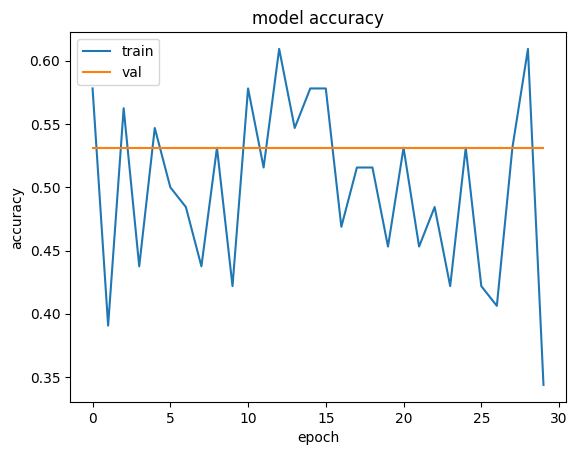

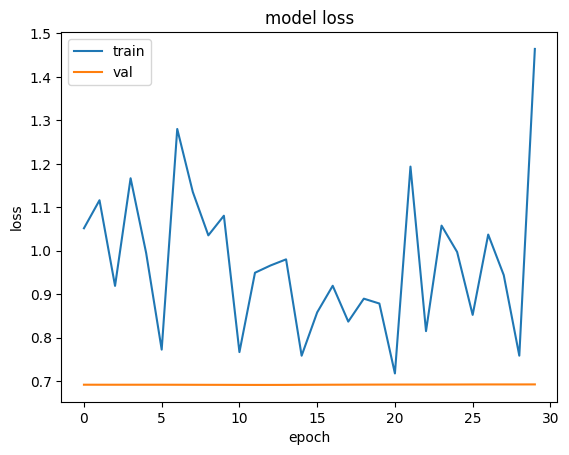

In [24]:
print(history3.history.keys())
# summarize history for accuracy durante el entrenamiento
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss  durante el entrenamiento
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# evaluate model3
loss, acc = model3.evaluate_generator(test_ds, steps=len(test_ds), verbose=0)
print('Test loss: %.3f' % (loss))
print('Test Accuracy: %.3f' % (acc))

Test loss: 0.694
Test Accuracy: 0.512



SUMARIO DEL MODELO 3


In [28]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, None)      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)      

CALCULO DE METRICAS

In [27]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import random

from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
for run in range(1):

    # Start a run, tracking hyperparameters
    wandb.init(
        project="ml-en-produccion_obl",
        config={

            "activation_1": "relu",
            "dropout": random.uniform(0.01, 0.80),
            "optimizer": "adam",
            "loss": "categorical_crossentropy",
            "metric": "accuracy",
            "epoch": 3,
            "batch_size": 128,
        },
    )
    config = wandb.config

    #data generator
    datagen = ImageDataGenerator()
    # Batch de 64
    # load
    train_ds = datagen.flow_from_directory(base_uri+'/train', class_mode='categorical', batch_size=64)
    # load
    val_ds = datagen.flow_from_directory(base_uri+'/val/', class_mode='categorical', batch_size=64)
    # load
    test_ds = datagen.flow_from_directory(base_uri+'/test/', class_mode='categorical', batch_size=64)




    batch_trainX, batchTrain_y = train_ds.next()
    batch_valX, batchval_y = val_ds.next()
    batch_testX, batchtest_y = test_ds.next()
    # Define el preprocesamiento de la imagen

    data_augmentation = Sequential([
        preprocessing.Rescaling(1./255),
        preprocessing.RandomRotation(0.15),
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomTranslation(0.1, 0.1),
        preprocessing.RandomContrast(0.2),
        preprocessing.RandomCrop(30, 30)
    ])

    # Definimos un modelo
    model3 = tf.keras.models.Sequential([
    data_augmentation,  # Agrega las capas de preprocesamiento al inicio del modelo



    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=config.activation_1, input_shape=(256, 256, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=config.activation_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(2, (3, 3), padding='same', activation=config.activation_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(2, (3, 3), padding='same', activation=config.activation_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(config.dropout),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation=config.activation_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(config.dropout),
    tf.keras.layers.Dense(2, activation='softmax')
])


    # Compila y entrena el modelo
    model3.compile(optimizer=config.optimizer, loss=config.loss,  metrics=[config.metric])

    # Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints

    wandb_callbacks = [
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
    ]

    history = model3.fit(batch_trainX, batchTrain_y, batch_size=config.batch_size, epochs=config.epoch, validation_data=(batch_valX, batchval_y), callbacks=wandb_callbacks)

    wandb.finish()



<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
def classify_image(image):

    image = np.expand_dims(image, axis=0)
    prediction = model3.predict(image)

    # Obtiene las etiquetas de las clases
    class_labels = ['Casa', 'Apartamento']

    # Devuelve un diccionario con las etiquetas de las clases y sus probabilidades correspondientes
    return {class_labels[i]: float(prediction[0][i]) for i in range(2)}

PUBLICACION EN GRADIO

In [ ]:
import gradio as gr

iface = gr.Interface(
    fn=classify_image,  # la función que hace la clasificación
    inputs=gr.inputs.Image(shape=(256, 256)),  # el tipo de entrada que espera tu modelo
    outputs=gr.outputs.Label(num_top_classes=3),  # el tipo de salida que produce tu modelo
)
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://aca56549a08bec7c54.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
